In [1]:
%cd ..
from dataloader.dataloader import CellNucleiDataset, get_augmentations
%cd notebooks


/home/maciej/github/cell_nuclei_segmentation/cell_nuclei_segmentation
/home/maciej/github/cell_nuclei_segmentation/cell_nuclei_segmentation/notebooks


In [2]:
from __future__ import annotations

import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from albumentations import Compose
import albumentations.pytorch
from PIL import Image
from torchvision.transforms import Resize, ToTensor

In [3]:
CURRENT_DIR = os.path.dirname(os.path.abspath("__file__"))


dataset = CellNucleiDataset.create(
    target_size=(1024, 1360),  # biggest image in the dataset
    transform=None,
    train=True,
)

Loading 42 training images


In [4]:
x, y = next(iter(dataset))

x.shape, y.shape

(torch.Size([1, 1024, 1360]), torch.Size([1024, 1360]))

## Plot X and y from the dataset

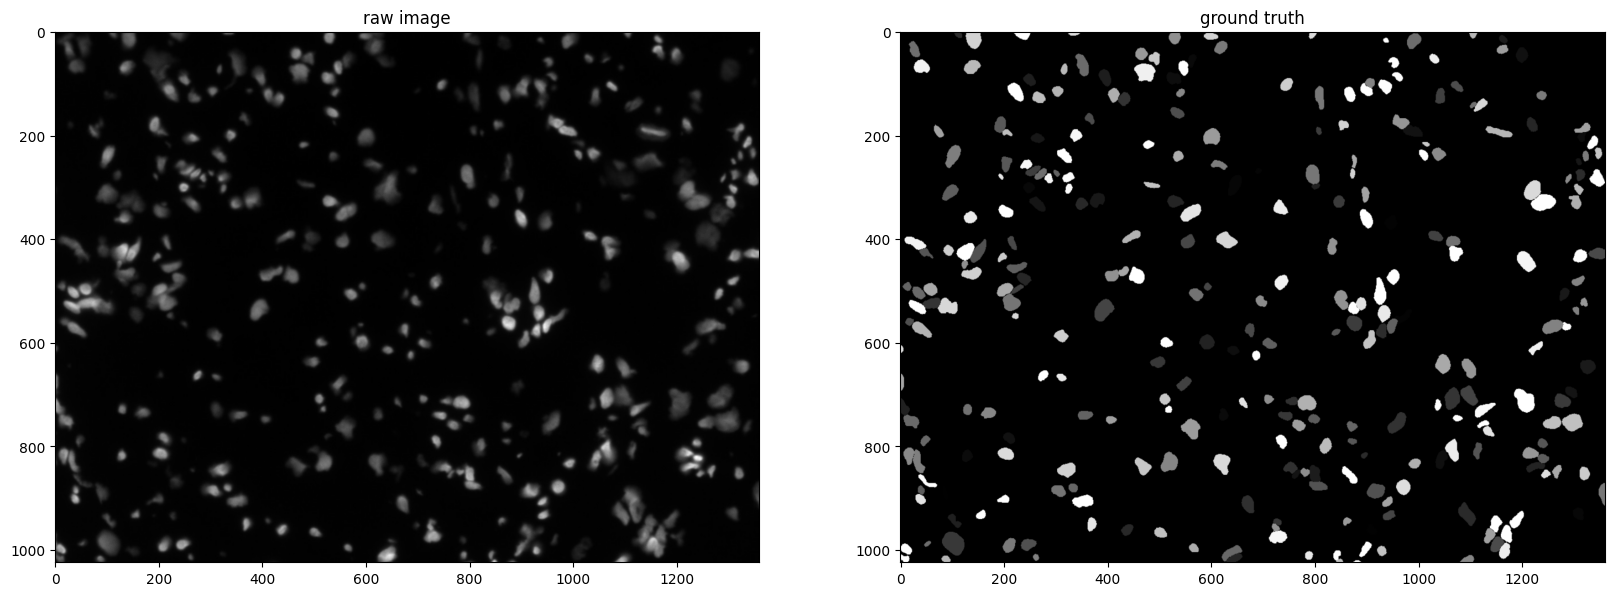

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))

axes[0].imshow(np.array(x)[0], cmap="gray")
axes[0].set_title("raw image")

axes[1].imshow(np.array(y), cmap="gray")
axes[1].set_title("ground truth")

plt.show()

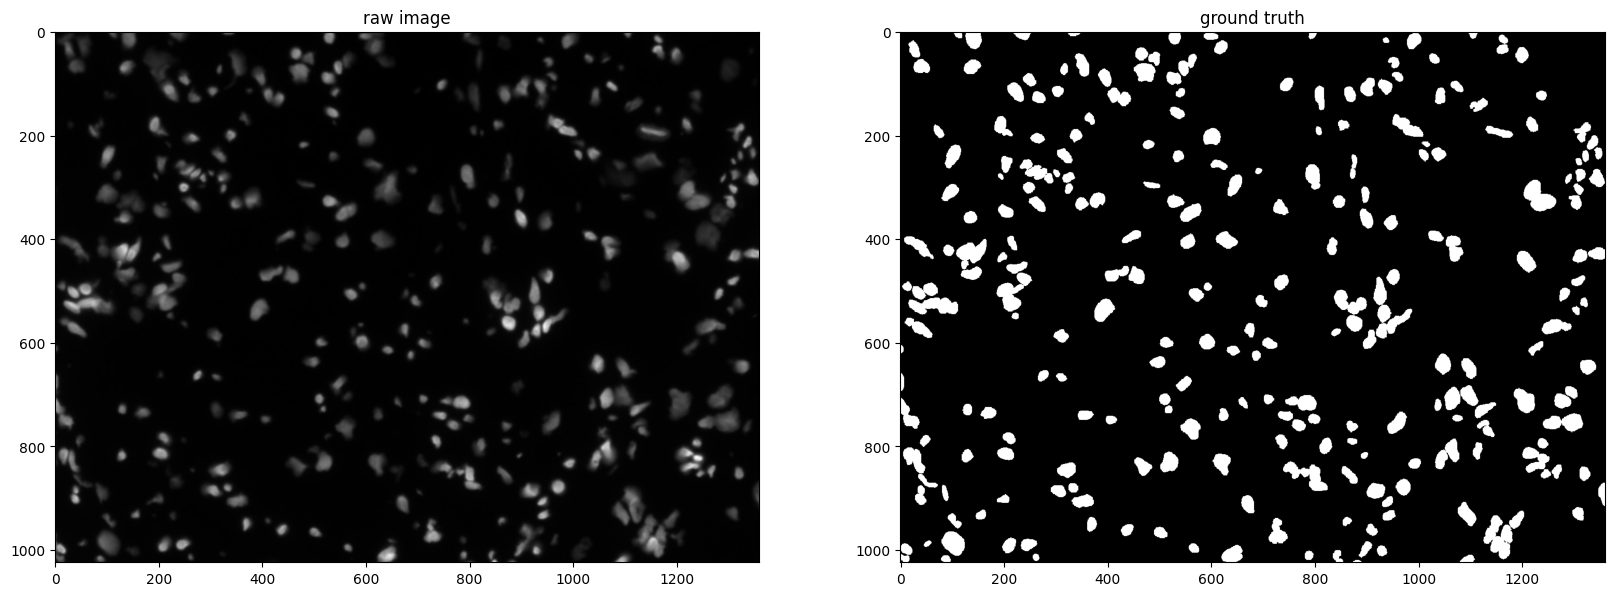

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))

axes[0].imshow(np.array(x)[0], cmap="gray")
axes[0].set_title("raw image")

axes[1].imshow(np.array(y) > 0, cmap="gray")
axes[1].set_title("ground truth")

plt.show()

## Visualize clusters with numbers

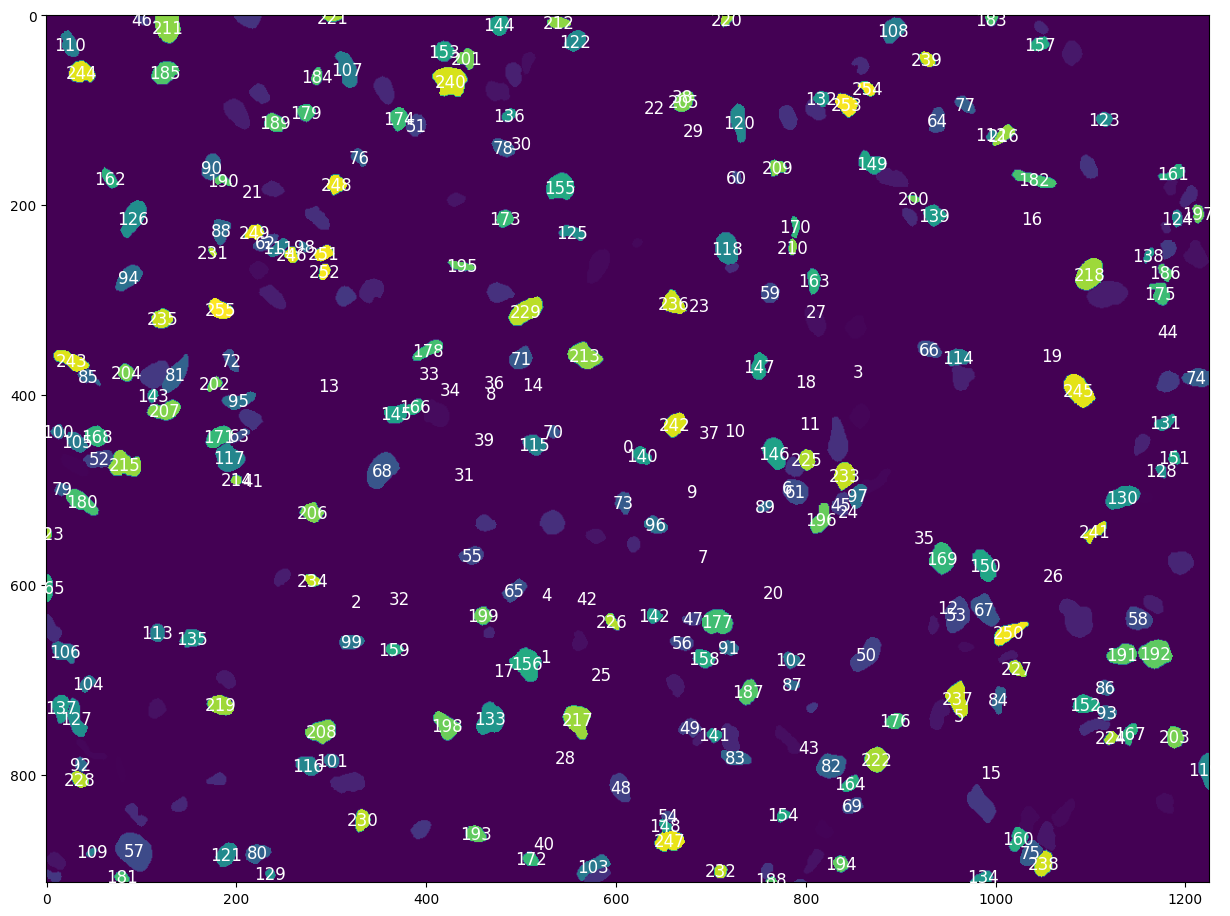

In [7]:
# Load the image as a numpy array
y_clusters = np.array(
    Image.open(os.path.join(CURRENT_DIR, '..', 'dataset', 'groundtruth', 'Ganglioneuroblastoma_0.tif')), 
    dtype=np.uint8
)

# Get the unique cluster labels
clusters = np.unique(y_clusters)

# Assign a color to each cluster label
cmap = plt.cm.viridis
colors = cmap(range(len(clusters)))

# Plot the image with colors assigned to each cluster
plt.figure(figsize=(15, 15))
plt.imshow(y_clusters, vmin=0, vmax=len(clusters)-1)

# Add cluster numbers as text annotations
for cluster in clusters:
    # Find the coordinates of the cluster label
    cluster_coords = np.where(y_clusters == cluster)

    # Compute the centroid of the cluster
    centroid = np.mean(cluster_coords, axis=1)

    # Add the cluster number as text annotation at the centroid
    plt.text(centroid[1], centroid[0], str(cluster), color='white', fontsize=12,
             horizontalalignment='center', verticalalignment='center')


plt.show()

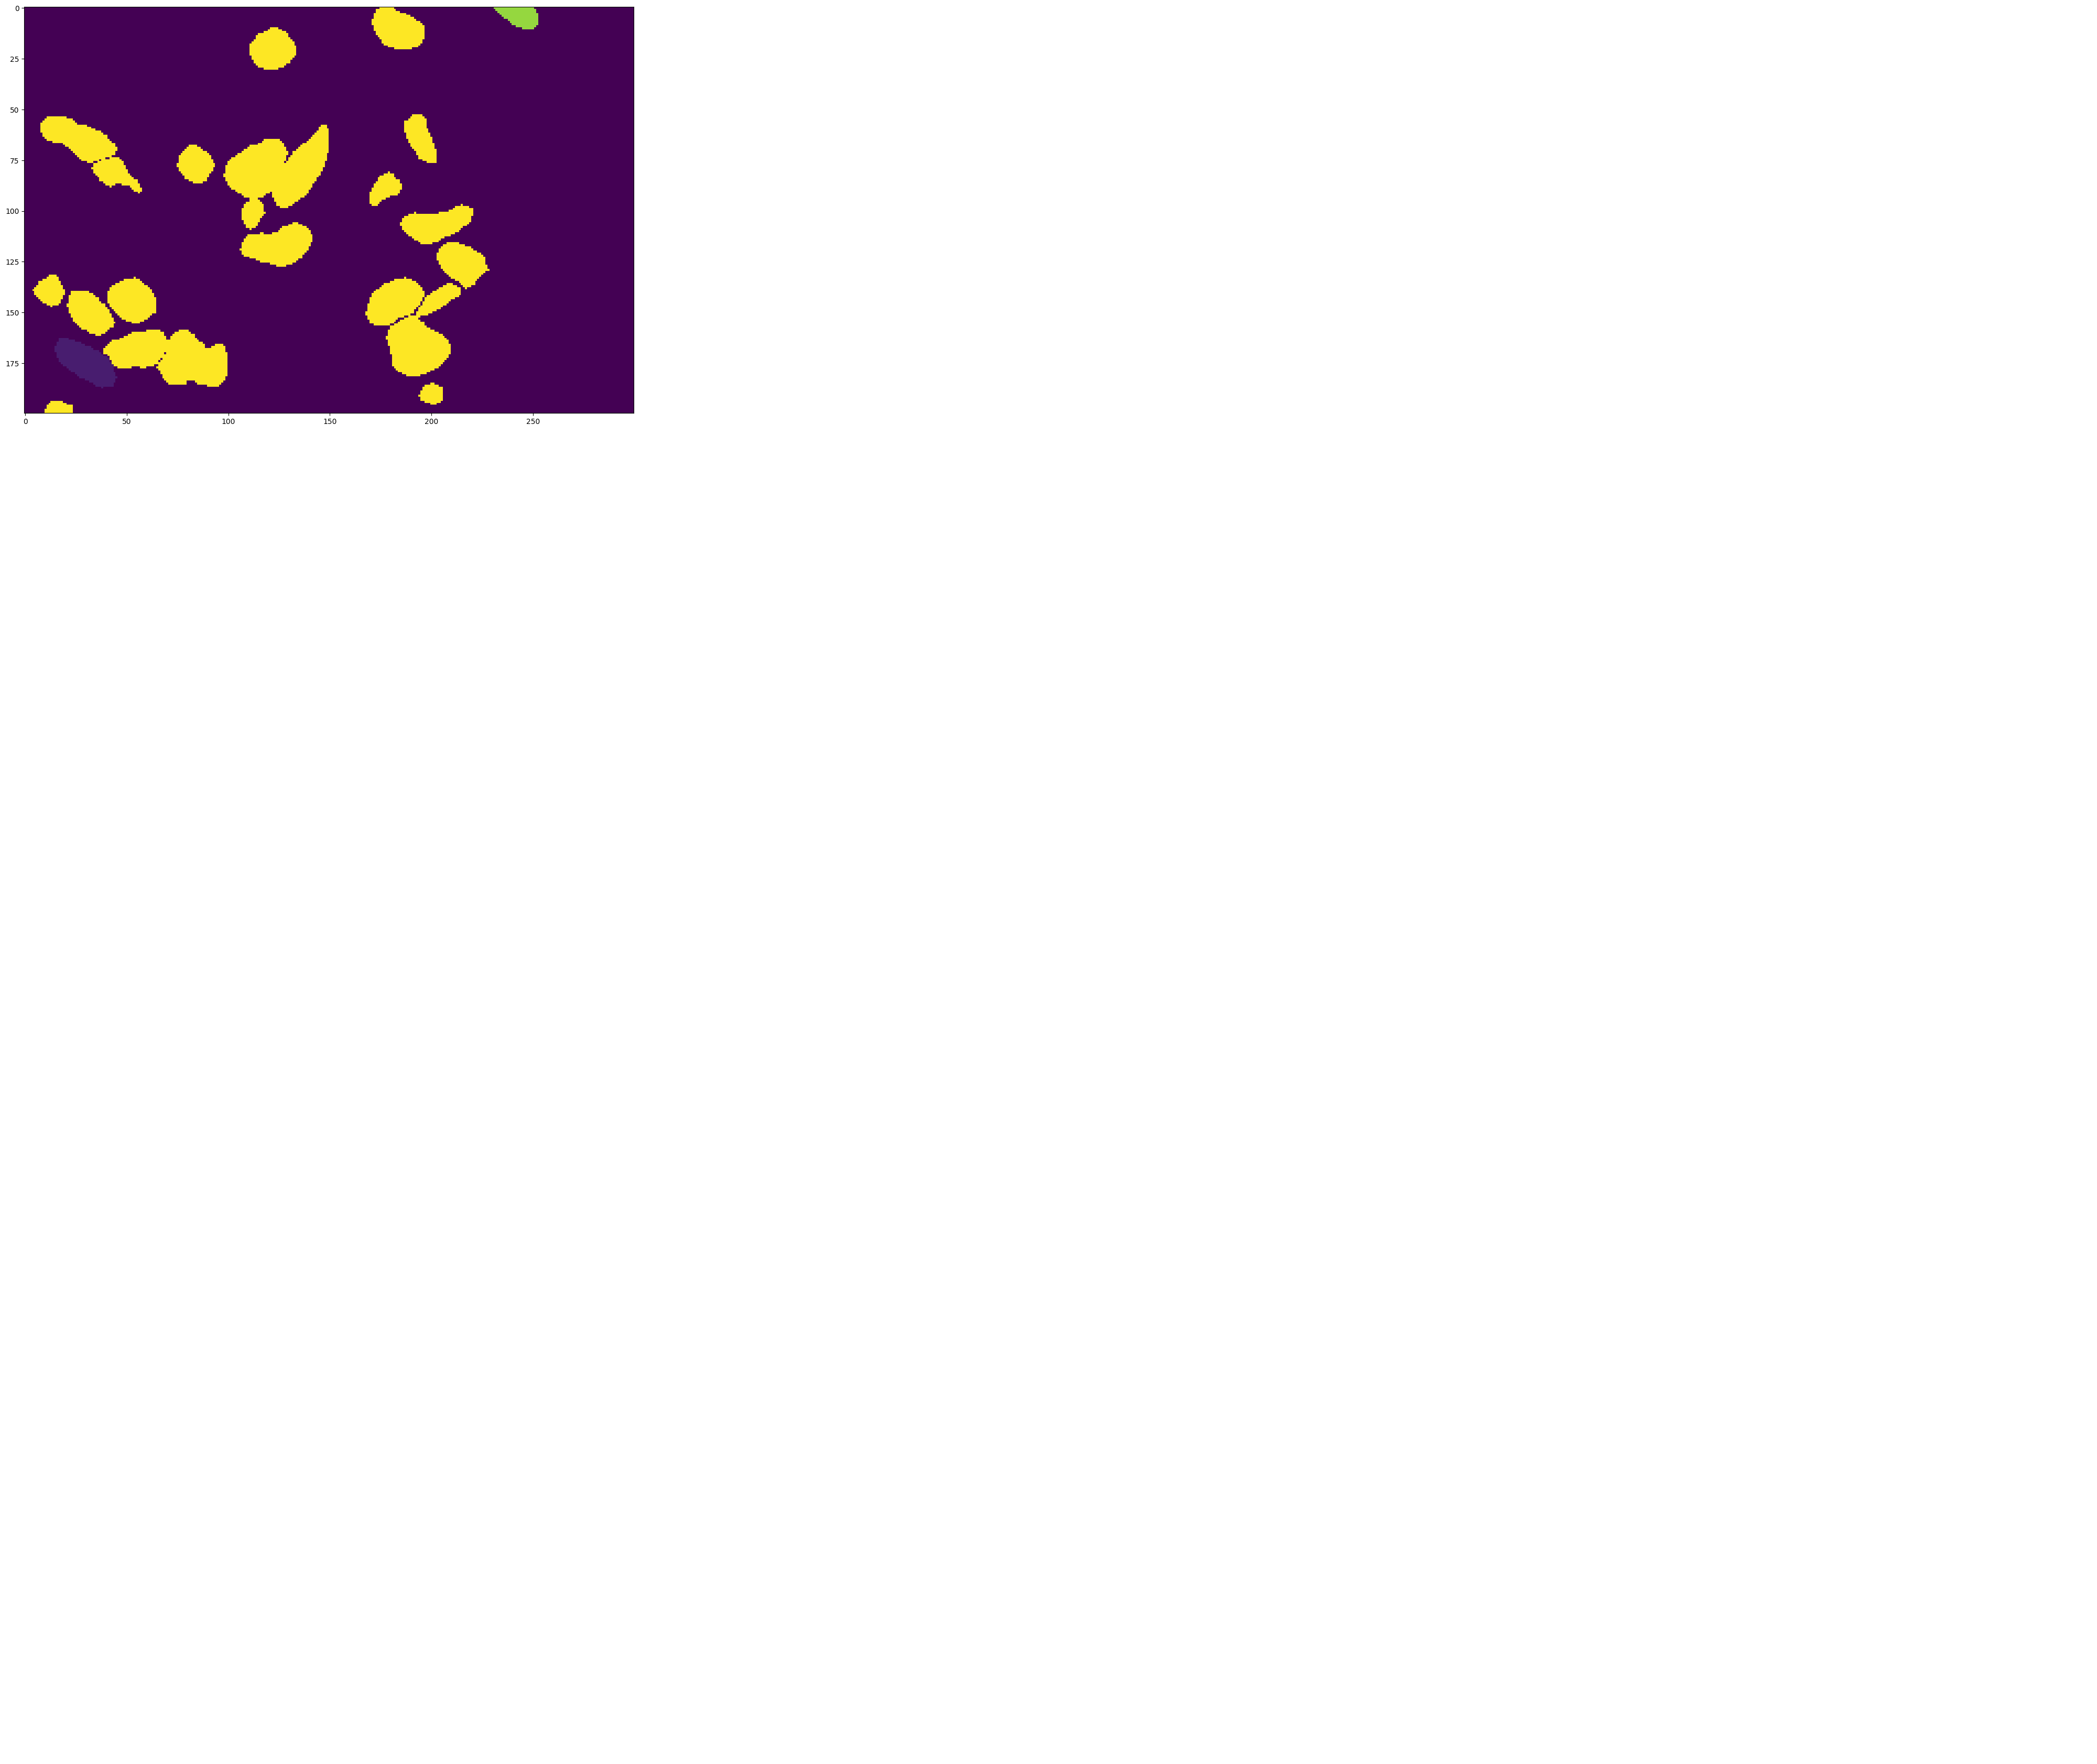

In [8]:
# Load the image as a numpy array
y_file = np.array(
    Image.open(os.path.join(CURRENT_DIR, '..', 'dataset', 'groundtruth', 'Ganglioneuroblastoma_0.tif')), 
    dtype=np.uint8
)

y_file = y_file[300:500, 0:300]
# Get the unique cluster labels
clusters = np.unique(y_file)

# Plot the image with colors assigned to each cluster
plt.figure(figsize=(15, 15))
plt.imshow(y_file, vmin=0, vmax=len(clusters)-1)

# Add cluster numbers as text annotations
for cluster in clusters:
    if cluster == 0:
        continue
    # Find the coordinates of the cluster label
    cluster_coords = np.where(y == cluster)

    # Compute the centroid of the cluster
    centroid = np.mean(cluster_coords, axis=1)

    # Add the cluster number as text annotation at the centroid
    plt.text(centroid[1], centroid[0], str(cluster), color='white', fontsize=12,
             horizontalalignment='center', verticalalignment='center')

plt.show()

## Augmentations

HorizontalFlip and VerticalFlip: These transformations will provide variations of the cells from different orientations.

Rotate: This can help the model to learn to recognize cells at different angles. However, be cautious with the degree of rotation. A full 360-degree rotation is usually not necessary because cells are often roughly symmetrical.

ShiftScaleRotate: This is a combination of random shifting, scaling, and rotation of the images, which can provide more variability in the training data.

ElasticTransform: This can simulate the deformable nature of biological tissues.

GaussNoise and GaussianBlur: These can help simulate variations in imaging conditions, such as focus and noise.

CLAHE (Contrast Limited Adaptive Histogram Equalization): This can help to improve the contrast of the cell images, potentially making it easier for the model to identify the cells.

In [9]:
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, Rotate, RandomBrightnessContrast, 
    RandomGamma, ElasticTransform, GridDistortion, OpticalDistortion, ShiftScaleRotate, 
    HueSaturationValue, GaussNoise, GaussianBlur, CLAHE
)

def get_augmentations():
    return Compose([
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        Rotate(limit=45, p=0.3),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.3),
        ElasticTransform(p=0.3),
        GaussianBlur(sigma_limit=(1, 3), blur_limit=(1, 3), p=0.2),
    ])

dataset = CellNucleiDataset.create(
    target_size=(1024, 1360),  # biggest image in the dataset
    transform=None,
    train=True,
)

Loading 42 training images


In [10]:
a = get_augmentations()

In [11]:
print(x.shape)
print(y.shape)

torch.Size([1, 1024, 1360])
torch.Size([1024, 1360])


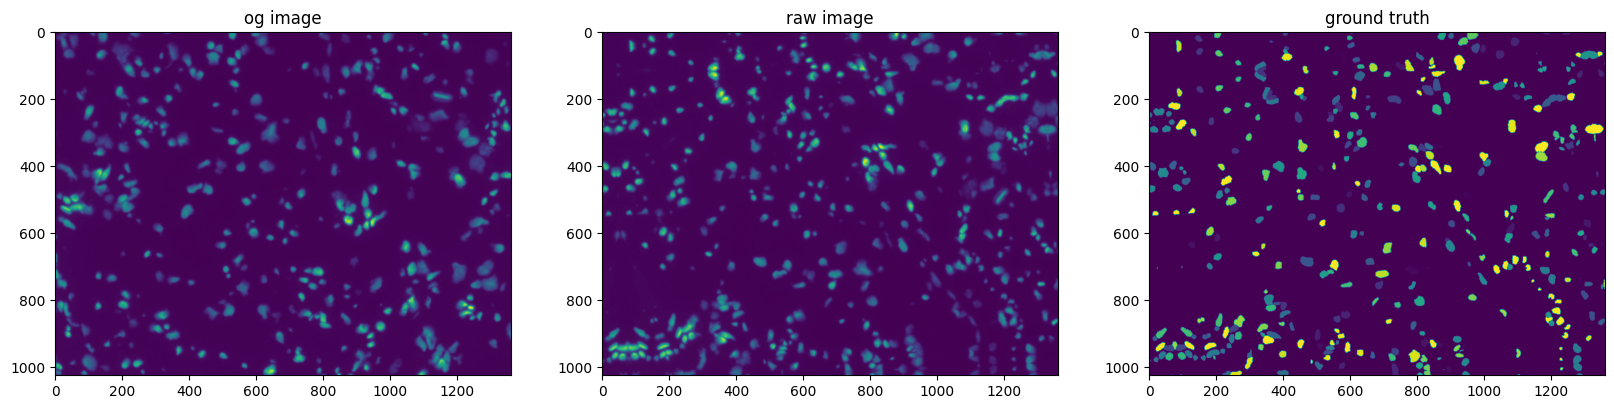

In [12]:
aug = a(image=x.numpy()[0], mask=y.numpy())
img = aug["image"]
mask = aug["mask"]

fig, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].imshow(x[0])
axes[0].set_title("og image")

axes[1].imshow(img)
axes[1].set_title("raw image")

axes[2].imshow(mask)
axes[2].set_title("ground truth")

plt.show()

## Test metrics on artificial data

In [13]:
def noisy_mask(mask: torch.tensor):
    classes = mask.unique()
    noise_mask = np.random.choice([0, 1], mask.shape, p=[999./1000, 1./1000])
    return mask * torch.tensor(noise_mask^1) + torch.tensor(noise_mask * np.random.randint(min(classes), max(max(classes)+1, max(classes)), mask.shape))

In [14]:
# y = torch.tensor(y)

In [15]:
y

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [16]:
y_noisy = noisy_mask(y)

In [17]:
x, y = next(iter(dataset))

x.shape, y.shape
def dice_coefficient(outputs, targets, smooth=1e-5):
    num_classes = len(targets[targets!=0].unique())
    dice_scores = torch.zeros(num_classes, dtype=torch.float32)

    for i in range(num_classes):
        output_binary = (outputs == i).float()
        target_binary = (targets == i).float()
        intersection = torch.sum(output_binary * target_binary)
        union = torch.sum(output_binary) + torch.sum(target_binary)
        dice_scores[i] = (2.0 * intersection + smooth) / (union + smooth)

    return dice_scores

dice_coefficient(y_noisy, y)

tensor([0.9995, 0.9978, 0.9990, 0.9976, 0.9970, 0.9983, 0.9974, 0.9969, 0.9943,
        0.9950, 0.9980, 0.9970, 0.9907, 0.9975, 0.9962, 0.9956, 0.9957, 0.9926,
        0.9964, 0.9968, 0.9959, 0.9980, 0.9944, 0.9965, 0.9953, 0.9948, 0.9924,
        0.9931, 0.9981, 0.9994, 0.9951, 0.9930, 0.9853, 0.9983, 0.9950, 0.9951,
        0.9965, 0.9933, 0.9940, 0.9952, 0.9923, 0.9973, 0.9964, 0.9984, 0.9948,
        0.9955, 0.9883, 0.9917, 0.9934, 0.9936, 0.9990, 0.9930, 0.9950, 0.9990,
        0.9909, 0.9973, 0.9908, 0.9973, 0.9975, 0.9950, 0.9929, 0.9975, 0.9939,
        0.9887, 0.9955, 0.9956, 0.9908, 0.9966, 0.9987, 0.9941, 0.9904, 0.9911,
        0.9937, 0.9899, 0.9968, 0.9940, 0.9909, 0.9947, 0.9950, 0.9880, 0.9922,
        0.9956, 0.9953, 0.9905, 0.9932, 0.9958, 0.9920, 0.9837, 0.9919, 0.9763,
        0.9968, 0.9889, 0.9852, 0.9923, 0.9948, 0.9957, 0.9925, 0.9971, 0.9909,
        0.9928, 0.9960, 0.9889, 0.9943, 0.9943, 0.9907, 0.9905, 0.9952, 0.9969,
        0.9932, 0.9890, 0.9979, 0.9885, 

In [18]:
def intersection_over_union(outputs, targets, smooth=1e-5):
    num_classes = len(targets[targets!=0].unique())
    iou_scores = torch.zeros(num_classes, dtype=torch.float32)

    for i in range(num_classes):
        output_binary = (outputs == i).float()
        target_binary = (targets == i).float()
        intersection = torch.sum(output_binary * target_binary)
        union = torch.sum(output_binary) + torch.sum(target_binary) - intersection
        iou_scores[i] = (intersection + smooth) / (union + smooth)

    return iou_scores

intersection_over_union(y_noisy, y)

tensor([0.9990, 0.9956, 0.9980, 0.9953, 0.9941, 0.9966, 0.9949, 0.9939, 0.9887,
        0.9901, 0.9960, 0.9939, 0.9816, 0.9950, 0.9925, 0.9912, 0.9915, 0.9853,
        0.9929, 0.9937, 0.9919, 0.9961, 0.9888, 0.9931, 0.9906, 0.9896, 0.9848,
        0.9864, 0.9961, 0.9987, 0.9902, 0.9860, 0.9709, 0.9967, 0.9901, 0.9903,
        0.9929, 0.9866, 0.9881, 0.9904, 0.9848, 0.9946, 0.9928, 0.9968, 0.9896,
        0.9910, 0.9768, 0.9836, 0.9869, 0.9872, 0.9980, 0.9861, 0.9900, 0.9981,
        0.9820, 0.9946, 0.9819, 0.9947, 0.9950, 0.9901, 0.9859, 0.9951, 0.9879,
        0.9777, 0.9910, 0.9913, 0.9818, 0.9932, 0.9975, 0.9883, 0.9810, 0.9823,
        0.9875, 0.9800, 0.9936, 0.9881, 0.9820, 0.9895, 0.9900, 0.9762, 0.9845,
        0.9912, 0.9906, 0.9812, 0.9866, 0.9915, 0.9841, 0.9679, 0.9840, 0.9537,
        0.9936, 0.9780, 0.9709, 0.9847, 0.9897, 0.9915, 0.9850, 0.9943, 0.9820,
        0.9857, 0.9921, 0.9781, 0.9886, 0.9886, 0.9815, 0.9812, 0.9904, 0.9938,
        0.9865, 0.9781, 0.9957, 0.9772, 

In [19]:
def average_precision(outputs, targets, smooth=1e-5):
    num_classes = len(targets[targets!=0].unique())
    ap_scores = torch.zeros(num_classes, dtype=torch.float32)

    for i in range(num_classes):
        output_binary = (outputs == i).float()
        target_binary = (targets == i).float()
        intersection = torch.sum(output_binary * target_binary)
        union = torch.sum(output_binary) + torch.sum(target_binary) - intersection
        ap_scores[i] = (intersection + smooth) / (union + smooth)

    return ap_scores.mean()

average_precision(y_noisy, y)

tensor(0.9854)

/tmp/ipykernel_111093/1668286787.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis").copy()


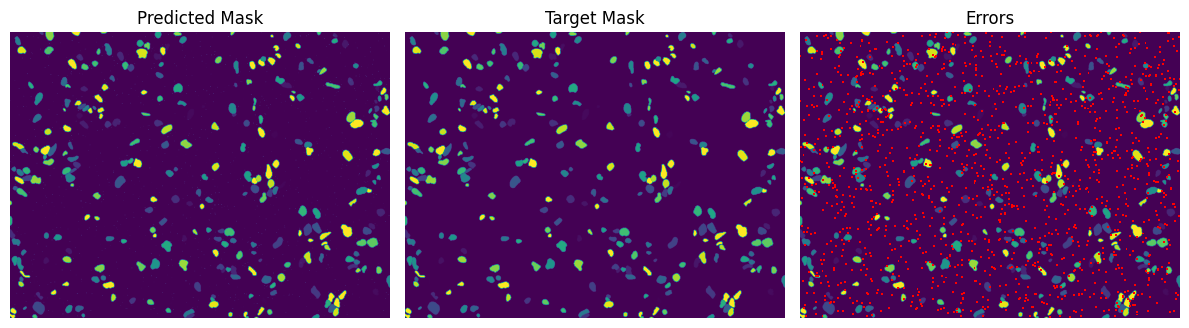

In [20]:
def error_analysis_plot(output, target):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    cmap = plt.cm.get_cmap("viridis").copy()
    cmap.set_bad(color='red')
    axes[0].imshow(output, cmap=cmap)
    axes[0].set_title('Predicted Mask')
    axes[1].imshow(target, cmap=cmap)
    axes[1].set_title('Target Mask')
    masked_array = np.ma.masked_where(output != target, target)
    axes[2].imshow(masked_array, cmap=cmap)
    axes[2].set_title('Errors')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

error_analysis_plot(y_noisy, y)